In [117]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
%matplotlib inline
print('tf',tf.__version__)

tf 2.3.1


In [2]:
dataset_path = 'data/npy_mfcc'
train_click_dir  = os.path.join(dataset_path,'train','click')
train_noClick_dir =  os.path.join(dataset_path,'train','noClick')
test_click_dir   = os.path.join(dataset_path,'test','click')
test_noClick_dir   = os.path.join(dataset_path,'test','noClick')

train_click = sorted(os.listdir(train_click_dir))
train_click = [os.path.join('train','click',ID) for ID in train_click]
train_noClick = sorted(os.listdir(train_noClick_dir))
train_noClick = [os.path.join('train','noClick',ID) for ID in train_noClick]
test_click = sorted(os.listdir(test_click_dir))
test_click = [os.path.join('test','click',ID) for ID in test_click]
test_noClick = sorted(os.listdir(test_noClick_dir))
test_noClick = [os.path.join('test','noClick',ID) for ID in test_noClick]

partition = {'train': train_click[:12600] + train_noClick[:12600],
             'validation': train_click[12600:] + train_noClick[12600:],
             'test': test_click + test_noClick}
labels = {}

for i, ID in enumerate(partition['train']):
    labels[ID] = 0 if i < 12600 else 1 
for i, ID in enumerate(partition['validation']):
    labels[ID] = 0 if i < 5400 else 1 
for i, ID in enumerate(partition['test']):
    labels[ID] = 0 if i < 2000 else 1 

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(501,13),
          n_channels=1, n_classes=2, shuffle=True, ARCH='CNN'):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.arch = ARCH
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.arch == 'LSTM':
                X[i,] = np.load(os.path.join('data/npy_mfcc', ID))
            elif self.arch == 'CNN':
                X[i,] = np.expand_dims(np.load(os.path.join('data/npy_mfcc', ID)), axis=2)
            # Store class
            y[i] = self.labels[ID]

        #return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

In [123]:
font = {'family': 'Hiragino Sans GB',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rcParams.update({'font.size': 16})

def plot_and_save_history(history, save_dir):
  
    np.save(os.path.join(save_dir, 'metrics', 'history.npy'), history.history)

    #fig, axs = plt.subplots(2)
    plt.figure(figsize=(15,10))
    fig1 = plt.subplot(2,1,1)
    # create accuracy subplot
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='val accuracy')
    plt.grid()
    fig1.set_ylabel('Accuracy')
    fig1.legend(loc='lower right')
    fig1.set_title('Accuracy')
    fig1.set_ylim(top=1)

    fig2 = plt.subplot(2,1,2)
    # create error subplot
    plt.plot(history.history['loss'],label='train loss')
    plt.plot(history.history['val_loss'],label='val loss')
    plt.grid()
    fig2.set_ylabel('Loss')
    fig2.set_xlabel('Epoch')
    fig2.legend(loc='upper right')
    fig2.set_title('Loss')
    fig2.set_ylim(bottom=0)

    plt.savefig(os.path.join(save_dir, 'loss_acc.png'))
    plt.show()

def plot_and_save_PR_curve(model, test_generator, save_dir):
    predictions = model.predict(test_generator)
    test_labels = np.concatenate((np.zeros(2000), np.ones(2000)))
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)

    np.save(os.path.join(save_dir, 'metrics', 'PR.npy'), {'precision': precision,
                                             'recall': recall})

    plt.figure(figsize=(15,10))
    plt.plot(recall,precision)
    plt.title('PR Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid()
    plt.savefig(os.path.join(save_dir, 'PR.png'))
    plt.show()

def cmp_history(CNN_dir, LSTM_dir, save_dir):
    
    CNN = np.load(os.path.join(CNN_dir,'metrics','history.npy'), allow_pickle=True)  
    LSTM = np.load(os.path.join(LSTM_dir,'metrics','history.npy'), allow_pickle=True)
    #fig, axs = plt.subplots(2)
    plt.figure(figsize=(15,10))
    fig1 = plt.subplot(2,1,1)
    # create accuracy subplot
    plt.plot(CNN.item()['accuracy'], 'c', label='CNN train accuracy')
    plt.plot(CNN.item()['val_accuracy'], 'm', label='CNN val accuracy')
    plt.plot(LSTM.item()['accuracy'], 'c--', label='LSTM train accuracy')
    plt.plot(LSTM.item()['val_accuracy'], 'm--', label='LSTM val accuracy')
    plt.grid()
    fig1.set_ylabel('Accuracy')
    fig1.legend(loc='lower right')
    fig1.set_title('Accuracy')
    fig1.set_ylim(top=1)
    fig1.set_ylim(bottom=.96)

    fig2 = plt.subplot(2,1,2)
    # create error subplot
    plt.plot(CNN.item()['loss'], 'c', label='CNN train loss')
    plt.plot(CNN.item()['val_loss'], 'm', label='CNN val loss')
    plt.plot(LSTM.item()['loss'], 'c--', label='LSTM train loss')
    plt.plot(LSTM.item()['val_loss'], 'm--', label='LSTM val loss')
    plt.grid()
    fig2.set_ylabel('Loss')
    fig2.set_xlabel('Epoch')
    fig2.legend(loc='upper right')
    fig2.set_title('Loss')
    fig2.set_ylim(top=0.2)
    fig2.set_ylim(bottom=0)

    plt.savefig(os.path.join(save_dir, 'cmp_hisory.png'))
    plt.show()

def cmp_PR(CNN_dir, LSTM_dir, save_dir):
    
      
    CNN = np.load(os.path.join(CNN_dir,'metrics','PR.npy'), allow_pickle=True)  
    LSTM = np.load(os.path.join(LSTM_dir,'metrics','PR.npy'), allow_pickle=True)

    plt.figure(figsize=(12,8))
    plt.plot(CNN.item()['recall'],CNN.item()['precision'],'c', label='CNN')
    plt.plot(LSTM.item()['recall'],LSTM.item()['precision'],'c--', label='LSTM')
    plt.title('PR Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc='lower left')
    plt.grid()
    plt.savefig(os.path.join(save_dir, 'cmp_PR.png'))
    plt.show()

def cmp_ROC(CNN_dir, LSTM_dir, save_dir):
    ground_truth = np.concatenate((np.zeros(2000), np.ones(2000)))
    CNN_p = np.load(os.path.join(CNN_dir,'CNN_predictions.npy'))
    LSTM_p = np.load(os.path.join(LSTM_dir,'LSTM_predictions.npy'))
    
    CNN_fpr, CNN_tpr, CNN_thresholds = metrics.roc_curve(ground_truth, CNN_p)
    LSTM_fpr, LSTM_fpr, LSTM_thresholds = metrics.roc_curve(ground_truth, LSTM_p)    
    plt.figure(figsize=(12,8))
    plt.plot(CNN_fpr, CNN_tpr, 'c', label='CNN')
    plt.plot(CNN_fpr, CNN_tpr, 'c--', label='LSTM')
    plt.plot(np.linspace(0,1,len(CNN_fpr)), np.linspace(0,1,len(CNN_fpr)), 'k.')
    plt.title('ROC Curve')
    plt.ylabel('True-positive rate')
    plt.xlabel('False-postive rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(os.path.join(save_dir, 'cmp_ROC.png'))
    plt.show()

In [5]:
batch_size = 32

#############################################

LSTM_params = {'dim': (501,),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 13,
          'shuffle': True}
LSTM_test_params = {'dim': (501,),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 13,
          'shuffle': False}

#############################################

CNN_params = {'dim': (501,13),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
CNN_test_params = {'dim': (501,13),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': False}

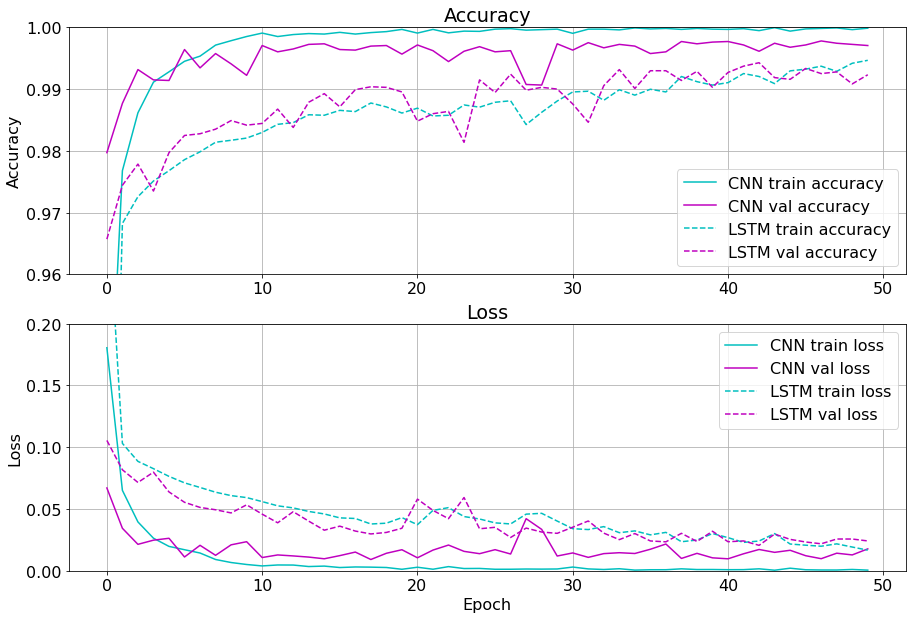

In [13]:
save_dir = 'models/comparisons/50e'
CNN_dir = 'models/CNN_50e'
LSTM_dir = 'models/LSTM_50e'

cmp_history(CNN_dir, LSTM_dir, save_dir)

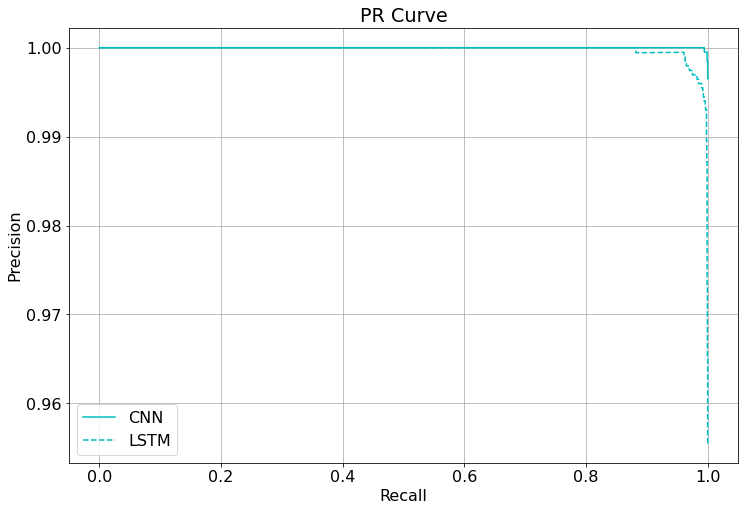

In [125]:
cmp_PR(CNN_dir, LSTM_dir, save_dir)

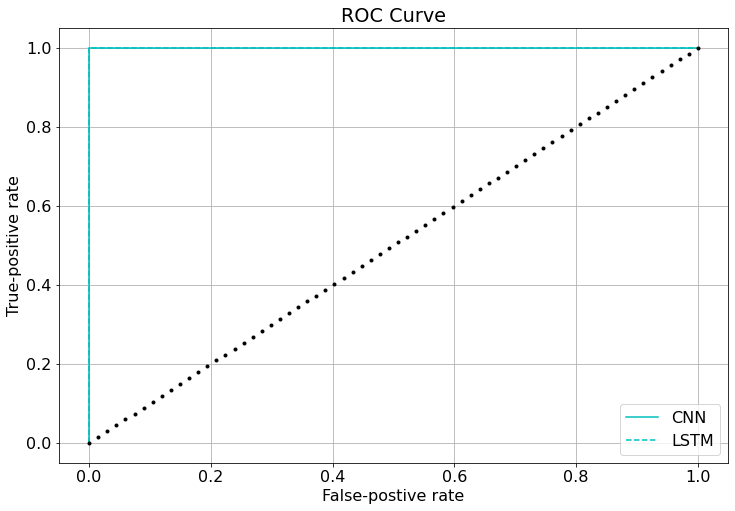

In [124]:
cmp_ROC(CNN_dir,LSTM_dir, save_dir)

# Get predictions

In [18]:
CNN = tf.keras.models.load_model(os.path.join(CNN_dir,'50e_0.0001_32.hdf5'))
LSTM = tf.keras.models.load_model(os.path.join(LSTM_dir,'50e_0.0001_32.hdf5'))
LSTM_test_generator = DataGenerator(partition['test'], labels, ARCH='LSTM', **LSTM_test_params)
CNN_test_generator = DataGenerator(partition['test'], labels, ARCH='CNN', **CNN_test_params)

In [63]:
print(f'CNN:\n{CNN.evaluate(CNN_test_generator)}')
print(f'LSTM:\n{LSTM.evaluate(LSTM_test_generator)}')

125/125 [==============================] - 7s 52ms/step - loss: 0.0084 - accuracy: 0.9975 - precision_1: 0.9950 - recall_1: 1.0000
CNN:
[0.008446883410215378, 0.9975000023841858, 0.9950248599052429, 1.0]
125/125 [==============================] - 5s 43ms/step - loss: 0.0226 - accuracy: 0.9927 - precision: 0.9871 - recall: 0.9985
LSTM:
[0.0226387120783329, 0.9927499890327454, 0.9871478080749512, 0.9984999895095825]


In [116]:
CNN_predictions = CNN.predict(CNN_test_generator)
LSTM_predictions = LSTM.predict(LSTM_test_generator)
np.save(os.path.join(CNN_dir,'CNN_predictions.npy'), CNN_predictions)
np.save(os.path.join(LSTM_dir,'LSTM_predictions.npy'), LSTM_predictions)

#### CNN Errors

In [49]:
n_rows = 4
n_cols = 4
img_dir = '/nfs/guille/eecs_research/soundbendor/deledani/half_second_image_data/gray/test'
ground_truth = np.concatenate((np.zeros(2000), np.ones(2000)))

In [93]:
CNN_errors = []
for i, (p, y) in enumerate(zip(CNN_predictions,ground_truth)):
    if round(float(p)) != y:
        label = 'click' if i < 2000 else 'noClick'
        fpath = f'{label}/test{18000 + i}.npy'
        print(f'Wrong at {fpath}')
        CNN_errors.append((fpath, 
                           np.load(os.path.join('data/npy_mfcc/test',fpath)),
                           CNN_predictions[i]))

Wrong at click/test18606.npy
Wrong at click/test18649.npy
Wrong at click/test19159.npy
Wrong at click/test19168.npy
Wrong at click/test19277.npy
Wrong at click/test19511.npy
Wrong at click/test19639.npy
Wrong at click/test19640.npy
Wrong at click/test19862.npy
Wrong at click/test19940.npy


#### LSTM Errors

In [111]:
LSTM_errors = []
for i, (p, y) in enumerate(zip(LSTM_predictions,ground_truth)):
    if round(float(p)) != y:
        label = 'click' if i < 2000 else 'noClick'
        fpath = f'{label}/test{18000 + i%2000}.npy'
        print(f'Wrong at {fpath}')
        LSTM_errors.append((fpath, 
                           np.load(os.path.join('data/npy_mfcc/test',fpath)),
                           LSTM_predictions[i]))

Wrong at click/test18133.npy
Wrong at click/test18166.npy
Wrong at click/test18365.npy
Wrong at click/test18379.npy
Wrong at click/test18414.npy
Wrong at click/test18419.npy
Wrong at click/test18606.npy
Wrong at click/test18665.npy
Wrong at click/test18765.npy
Wrong at click/test18800.npy
Wrong at click/test18848.npy
Wrong at click/test18931.npy
Wrong at click/test19173.npy
Wrong at click/test19195.npy
Wrong at click/test19315.npy
Wrong at click/test19361.npy
Wrong at click/test19485.npy
Wrong at click/test19511.npy
Wrong at click/test19543.npy
Wrong at click/test19640.npy
Wrong at click/test19655.npy
Wrong at click/test19657.npy
Wrong at click/test19691.npy
Wrong at click/test19807.npy
Wrong at click/test19935.npy
Wrong at click/test19940.npy
Wrong at noClick/test18974.npy
Wrong at noClick/test19317.npy
Wrong at noClick/test19948.npy


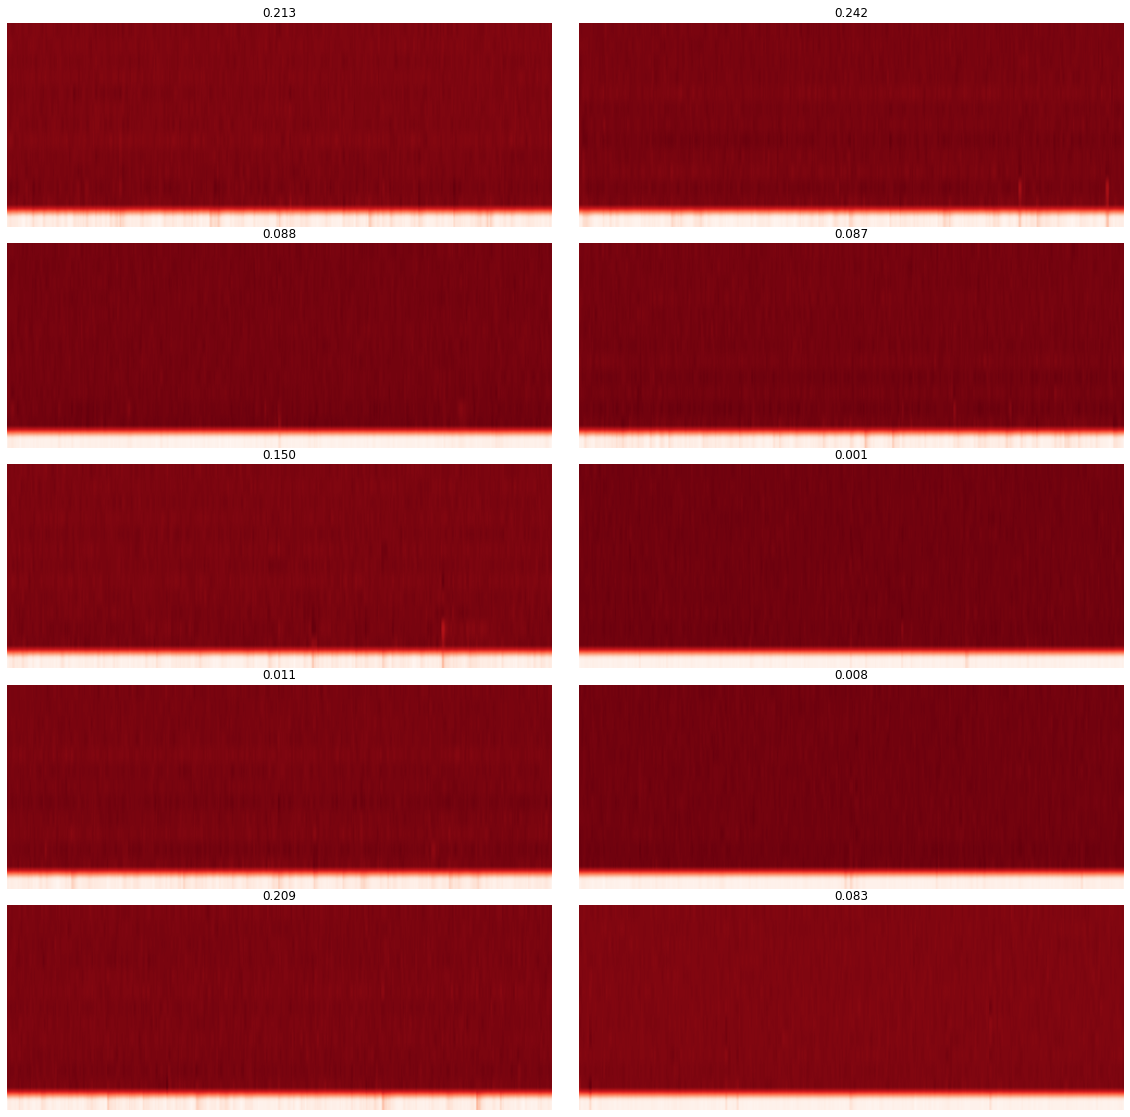

In [110]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
for idx, error in enumerate(CNN_errors):
    row = idx // 2
    col = idx % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(error[1].T, cmap='Reds', aspect="auto", origin='lower')
    axes[row,col].set_title(f'{1 - error[2][0]:.3f}')
plt.subplots_adjust(wspace=.05, hspace=.08)
plt.show()

[0.58832854]


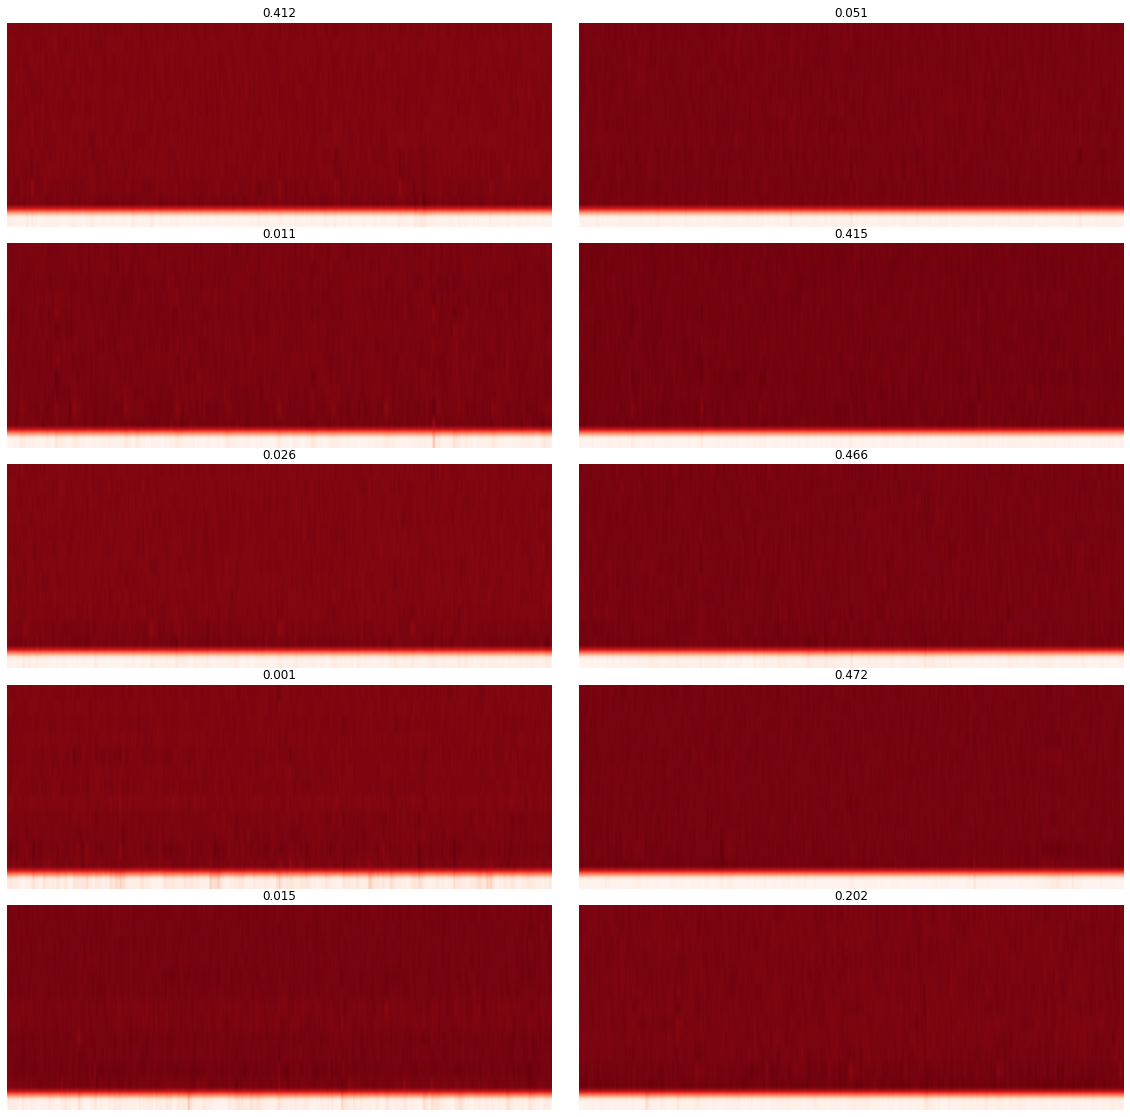

In [113]:
print(LSTM_errors[0][2])
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
for idx, error in enumerate(LSTM_errors[:10]):
    row = idx // 2
    col = idx % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(error[1].T, cmap='Reds', aspect="auto", origin='lower')
    axes[row,col].set_title(f'{1 - error[2][0]:.3f}')
plt.subplots_adjust(wspace=.05, hspace=.08)
plt.show()

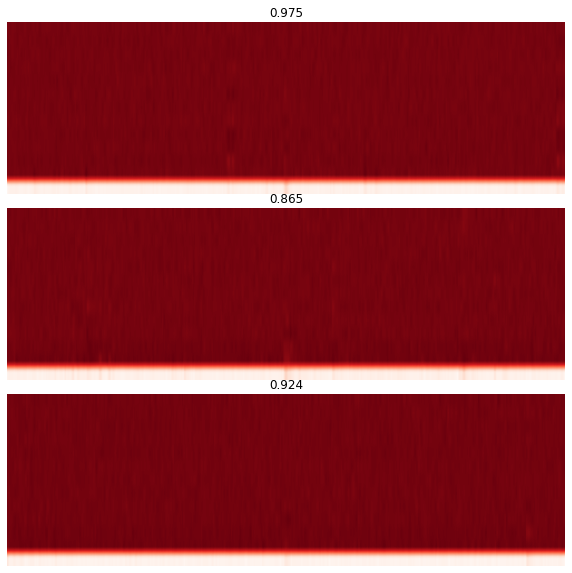

In [115]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
for idx, error in enumerate(LSTM_errors[-3:]):
    row = idx // 1
    col = idx % 1
    axes[row].axis("off")
    axes[row].imshow(error[1].T, cmap='Reds', aspect="auto", origin='lower')
    axes[row].set_title(f'{1 - error[2][0]:.3f}')
plt.subplots_adjust(wspace=.05, hspace=.08)
plt.show()